# VaR Estimation and Backtesting Using Historical, Jump Diffusion, and Rough Volatility Models

### Libraries and Packages

In [197]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde, norm, kurtosis
from fbm import FBM
from hurst import compute_Hc

## Data

In [218]:
# Define ticker, dates and download data
ticker = "^GSPC"  # S&P 500
start_date = "2006-01-01"
end_date = "2025-04-18"

sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Save CSV
sp500_data.to_csv("C:/Users/ferra/OneDrive/Escritorio/UPF/4T ECONOMIA/3. TFG/DATA/SP500_2006_2024.csv")

# Show first rows
print(sp500_data.head())
print(sp500_data.tail())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2006-01-03  1268.800049  1270.219971  1245.739990  1248.290039  2554570000
2006-01-04  1273.459961  1275.369995  1267.739990  1268.800049  2515330000
2006-01-05  1273.479980  1276.910034  1270.300049  1273.459961  2433340000
2006-01-06  1285.449951  1286.089966  1273.479980  1273.479980  2446560000
2006-01-09  1290.150024  1290.780029  1284.819946  1285.449951  2301490000
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2025-04-11  5363.359863  5381.459961  5220.770020  5255.560059  5602550000
2025-04-14  5405.970215  5459.459961  5358.020020  5441.959961  5031440000
2025-04-15  5396.629883  

## Historical Volatility

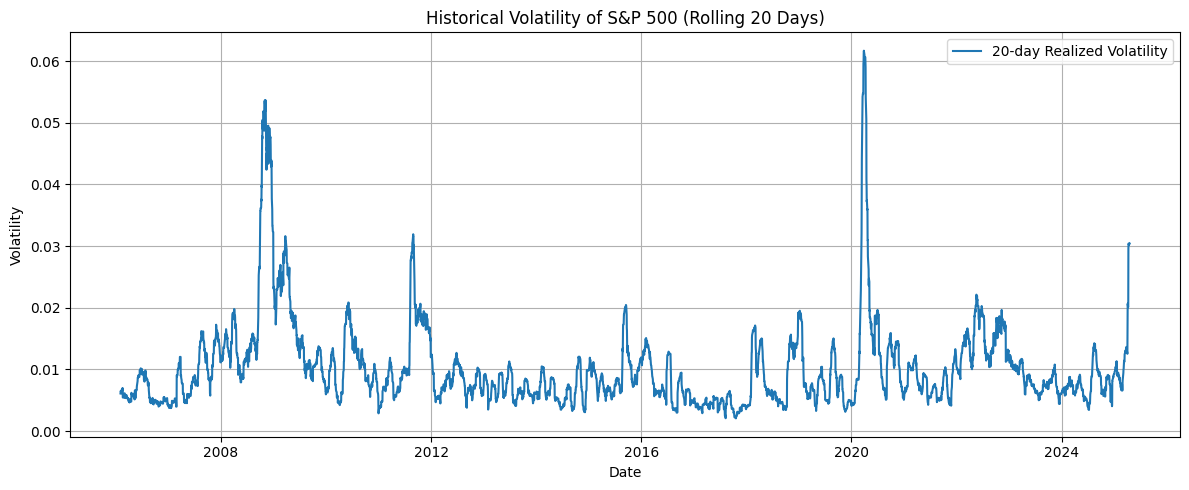

In [219]:
# Compute daily log returns
sp500_data["Log_return"] = np.log(sp500_data["Close"] / sp500_data["Close"].shift(1))

# Calculate historical volatility using a 20-day rolling window
window = 20
sp500_data["realized_volatility_20d"] = sp500_data["Log_return"].rolling(window=window).std()

# Drop missing values generated by rolling operation
sp500_data.dropna(inplace=True)

plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data["realized_volatility_20d"], label="20-day Realized Volatility")
plt.title("Historical Volatility of S&P 500 (Rolling 20 Days)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### VaR simulation using historical volatility

In [220]:
# Parameters for simulation
S0 = 100  
T = 1 / 252  
n_sim = 10000
np.random.seed(42)

returns = sp500_data["Log_return"].dropna()
sigma = returns.std()
mu = returns.mean() * 252

# Standard price simulation
Z = np.random.normal(0, 1, n_sim)
S_hist = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
returns_hist = (S_hist - S0) / S0

# VaR computation
VaR_95_hist = -np.percentile(returns_hist, 5) * S0
VaR_99_hist = -np.percentile(returns_hist, 1) * S0

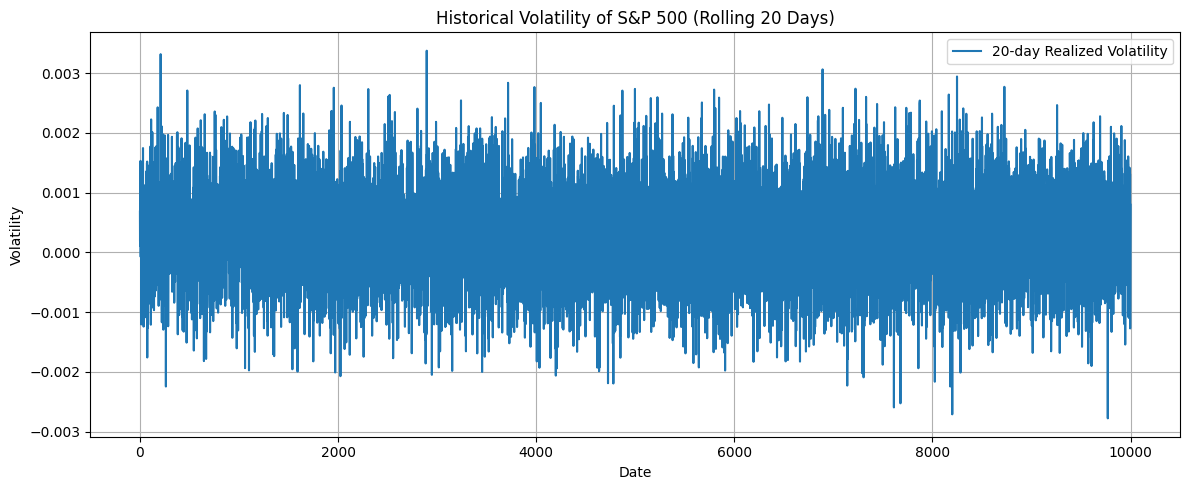

In [221]:
plt.figure(figsize=(12, 5))
plt.plot(returns_hist, label="20-day Realized Volatility")
plt.title("Historical Volatility of S&P 500 (Rolling 20 Days)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [222]:
# Output
print("Estimated standard parameters:")
print(f"  σ: {sigma:.4f}")
print(f"  μ: {mu:.4f}")

print("\nSimulated 1-day VaR using Historical Volatility:")
print(f"  VaR 95%: {VaR_95_hist:.4f}")
print(f"  VaR 99%: {VaR_99_hist:.4f}")

Estimated standard parameters:
  σ: 0.0124
  μ: 0.0739

Simulated 1-day VaR using Historical Volatility:
  VaR 95%: 0.1004
  VaR 99%: 0.1526


#### Other plots (Historical)

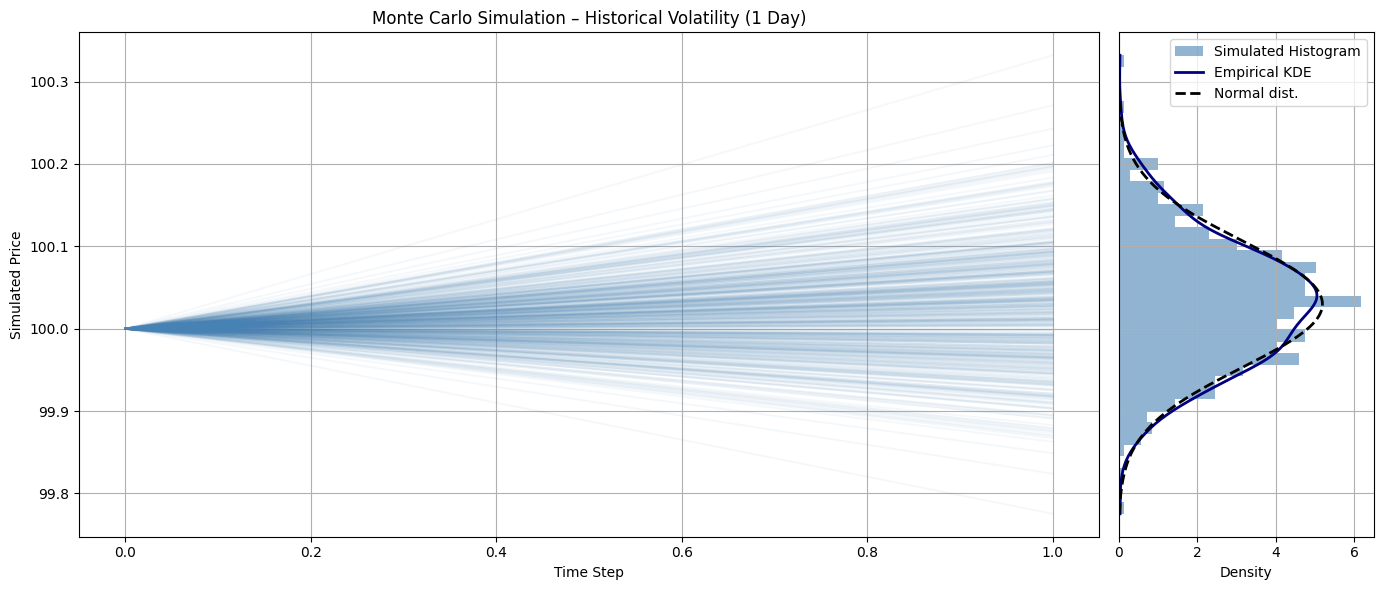

In [223]:
# Trajectiores simulation-----------------------------------------------------------------------------------
n_paths = 500
dt = T
np.random.seed(42)

# Trajectiories simulation
S_paths = np.zeros(n_paths)
all_paths = []

for i in range(n_paths):
    Z = np.random.normal(0, 1)
    S1 = S0 * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    S_paths[i] = S1
    all_paths.append([S0, S1])

all_paths = np.array(all_paths).T

# Densities estimation
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# Combined plot
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], all_paths[:, i], alpha=0.05, color='steelblue')
ax0.set_title("Monte Carlo Simulation – Historical Volatility (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=40, orientation='horizontal', color='steelblue', alpha=0.6, density=True, label="Simulated Histogram")
ax1.plot(kde_vals, y_vals, color='navy', lw=2, label="Empirical KDE")
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label="Normal dist.")
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.show()

## Jump-Diffusion Models

### VaR simulation using Merton Jump-Diffusion model

In [252]:
# Estimate jump parameters empirically
# Set a threshold for jump detection
threshold = 2.5 * sigma

# Identify jumps as extreme return events
jumps = returns[np.abs(returns) > threshold]

# Estimate parameters
lambda_jump = len(jumps) / len(returns)         
mu_J = jumps.mean()                             
sigma_J = jumps.std()                                     

# Simulate jump component
np.random.seed(42)
N_jumps = np.random.poisson(lambda_jump * T, n_sim)
J = np.random.normal(mu_J, sigma_J, n_sim) * N_jumps

# Simulate diffusion component
Z = np.random.normal(0, 1, n_sim)
S_jump = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z + J)

# === Compute returns and Value at Risk ===
returns_jump = (S_jump - S0) / S0
VaR_95_Merton = -np.percentile(returns_jump, 5) * S0
VaR_99_Merton = -np.percentile(returns_jump, 1) * S0

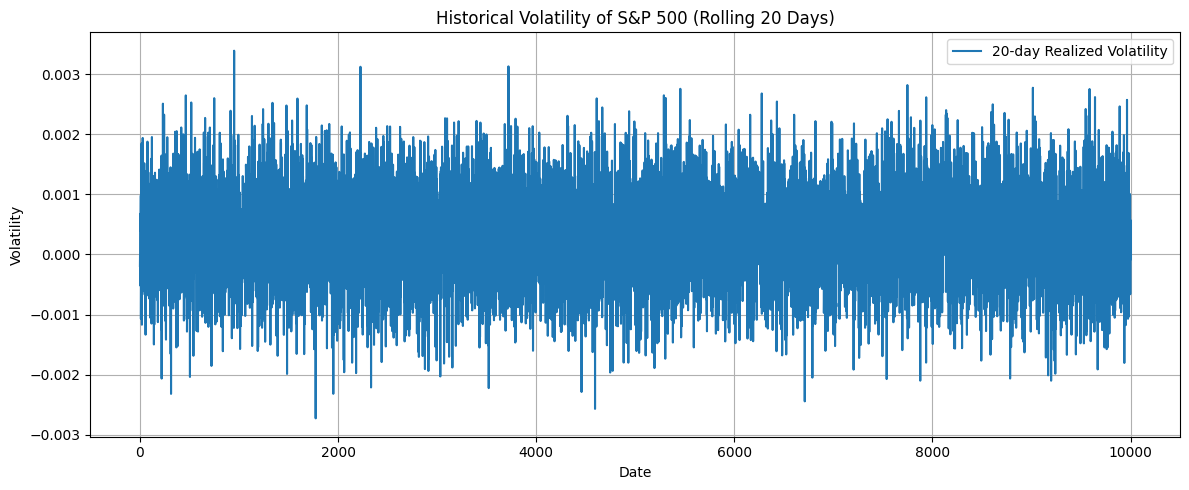

In [253]:
plt.figure(figsize=(12, 5))
plt.plot(returns_jump, label="20-day Realized Volatility")
plt.title("Historical Volatility of S&P 500 (Rolling 20 Days)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [172]:
# Output
print("Estimated Merton parameters:")
print(f"  λ (jumps/day): {lambda_jump:.4f}")
print(f"  μ_J (avg. jump size): {mu_J:.4f}")
print(f"  σ_J (jump std dev): {sigma_J:.4f}")
print(f"  Total jumps detected: {len(jumps)} / {len(returns)} days")

print("\nSimulated 1-day Merton Jump Diffusion VaR:")
print(f"  VaR 95%: {VaR_95_Merton:.4f}")
print(f"  VaR 99%: {VaR_99_Merton:.4f}")

Estimated Merton parameters:
  λ (jumps/day): 0.0269
  μ_J (avg. jump size): -0.0090
  σ_J (jump std dev): 0.0505
  Total jumps detected: 130 / 4834 days

Simulated 1-day Merton Jump Diffusion VaR:
  VaR 95%: 0.0966
  VaR 99%: 0.1511


#### Other plots (Merton)

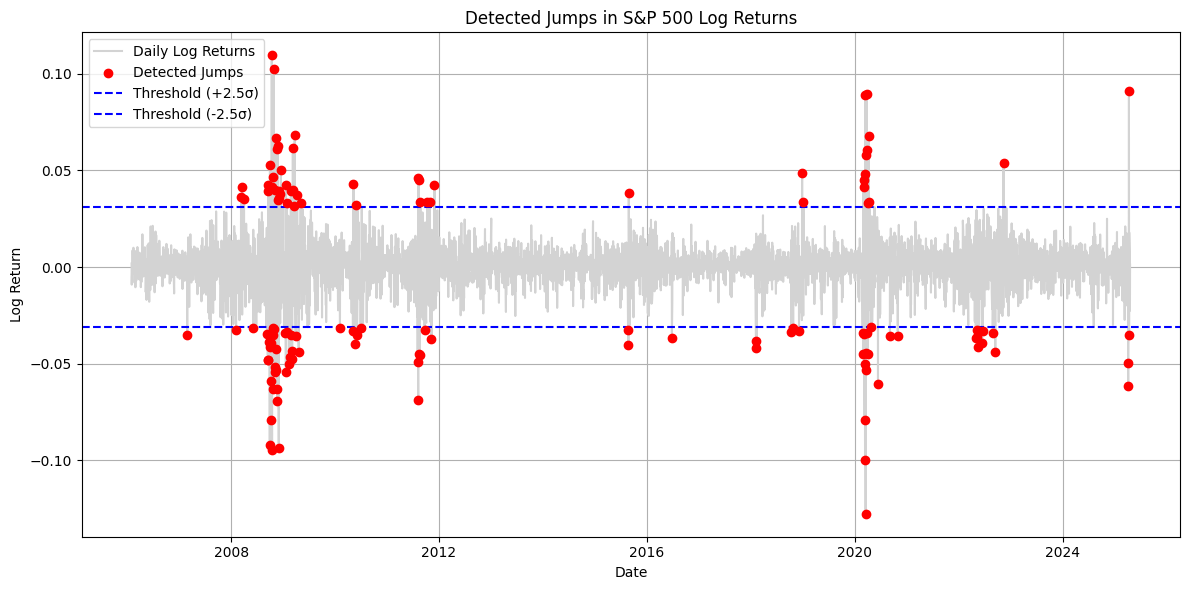

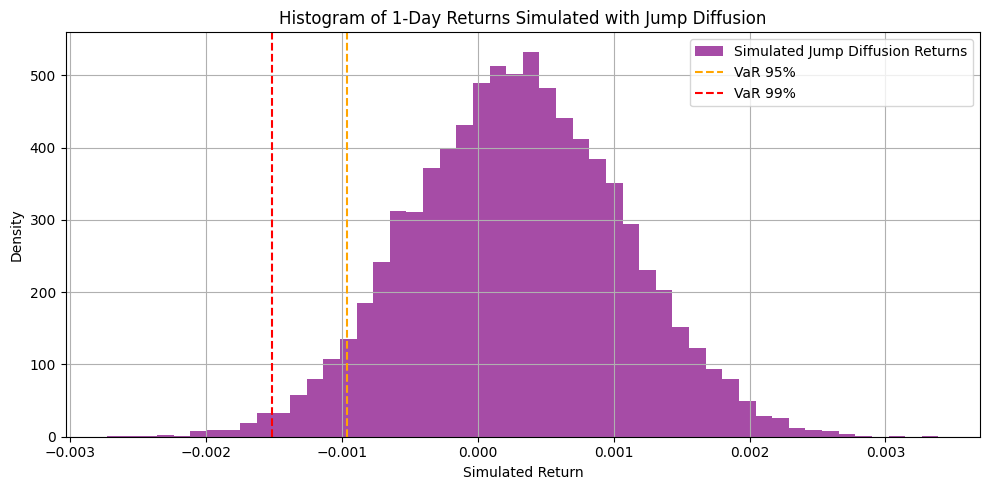

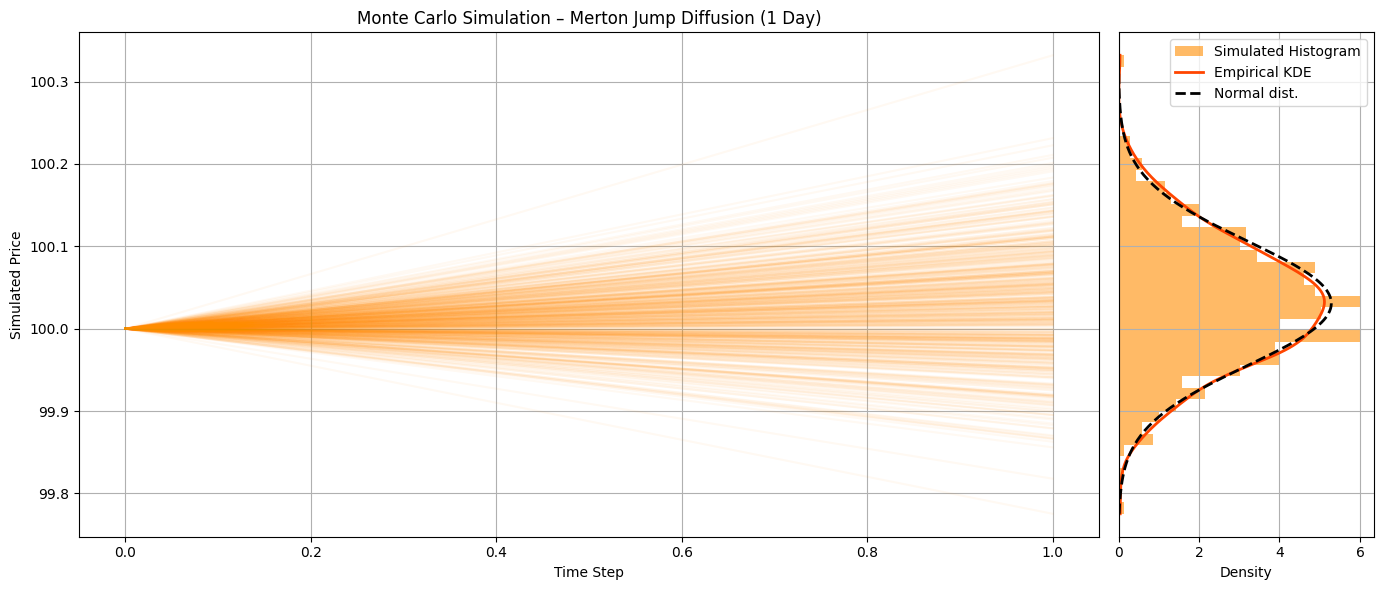

In [173]:
# Plot all returns and highlight the jumps---------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns, label='Daily Log Returns', color='lightgray')
plt.scatter(jumps.index, jumps, color='red', label='Detected Jumps', zorder=5)
plt.axhline(threshold, color='blue', linestyle='--', label='Threshold (+2.5σ)')
plt.axhline(-threshold, color='blue', linestyle='--', label='Threshold (-2.5σ)')
plt.title("Detected Jumps in S&P 500 Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the distribution of returns------------------------------------------------------------------------
plt.figure(figsize=(10, 5))
plt.hist(returns_jump, bins=50, density=True, alpha=0.7, color='purple', label='Simulated Jump Diffusion Returns')
plt.axvline(-VaR_95 / S0, color='orange', linestyle='--', label='VaR 95%')
plt.axvline(-VaR_99 / S0, color='red', linestyle='--', label='VaR 99%')
plt.title("Histogram of 1-Day Returns Simulated with Jump Diffusion")
plt.xlabel("Simulated Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Trajectiores simulation-----------------------------------------------------------------------------------
n_paths = 500
np.random.seed(42)

# Trajectiories simulation
S_paths = np.zeros(n_paths)
all_paths = []

for i in range(n_paths):
    Z = np.random.normal(0, 1)
    jumps_count = np.random.poisson(lambda_jump * dt)
    J = np.sum(np.random.normal(mu_J, sigma_J, jumps_count)) if jumps_count > 0 else 0
    S1 = S0 * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + J)
    S_paths[i] = S1
    all_paths.append([S0, S1])

all_paths = np.array(all_paths).T

# Densities estimation
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# Combined plot
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], all_paths[:, i], alpha=0.05, color='darkorange')
ax0.set_title("Monte Carlo Simulation – Merton Jump Diffusion (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=40, orientation='horizontal', color='darkorange', alpha=0.6, density=True, label="Simulated Histogram")
ax1.plot(kde_vals, y_vals, color='orangered', lw=2, label="Empirical KDE")
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label="Normal dist.")
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.show()

### VaR simulation using Kou Jump-Diffusion model

In [178]:
# Separate positive and negative jumps
jumps_pos = jumps[jumps > 0]
jumps_neg = jumps[jumps < 0]

# Estimate Kou parameters from jump data
p_kou = len(jumps_pos) / len(jumps)                         
eta1_kou = 1 / jumps_pos.mean() if len(jumps_pos) > 0 else np.nan  
eta2_kou = 1 / abs(jumps_neg.mean()) if len(jumps_neg) > 0 else np.nan 

lambda_kou = lambda_jump  # Use same jump frequency estimated earlier

# Simulate jump component: double exponential
def simulate_kou_jumps(n, lmbda, dt, p_kou, eta1_kou, eta2_kou):
    N = np.random.poisson(lmbda * dt, n)
    J = np.zeros(n)
    for i in range(n):
        for _ in range(N[i]):
            if np.random.rand() < p_kou:
                J[i] += np.random.exponential(1 / eta1_kou)  # positive jump
            else:
                J[i] -= np.random.exponential(1 / eta2_kou)  # negative jump
    return J

# Simulate
J_kou = simulate_kou_jumps(n_sim, lambda_kou, T, p_kou, eta1_kou, eta2_kou)

# Simulate full price paths
Z = np.random.normal(0, 1, n_sim)
S_kou = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z + J_kou)

# Compute returns and VaR
returns_kou = (S_kou - S0) / S0
VaR_95_kou = -np.percentile(returns_kou, 5) * S0
VaR_99_kou = -np.percentile(returns_kou, 1) * S0

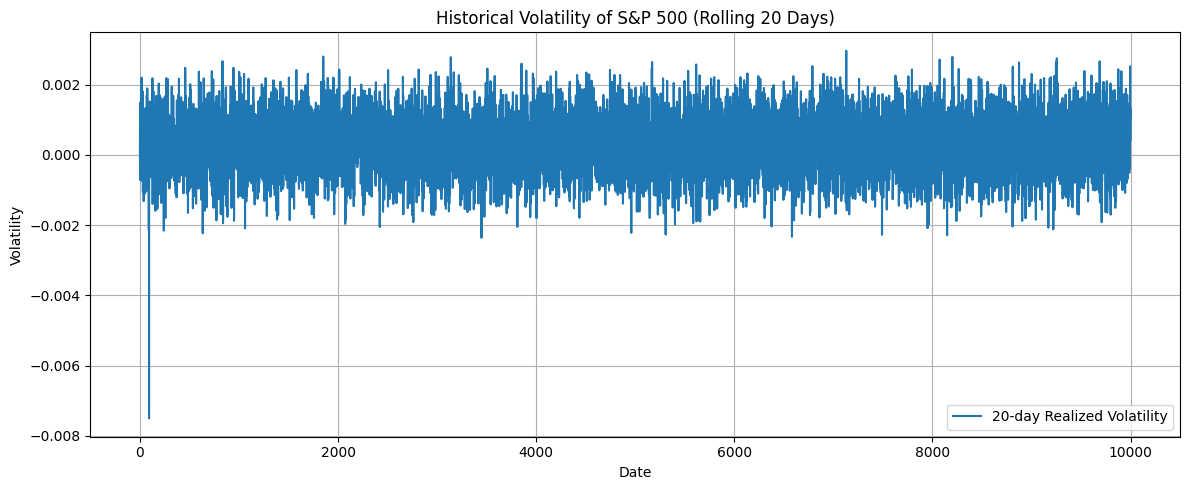

In [179]:
plt.figure(figsize=(12, 5))
plt.plot(returns_kou, label="20-day Realized Volatility")
plt.title("Historical Volatility of S&P 500 (Rolling 20 Days)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [180]:
# Output
print("Estimated Kou parameters:")
print(f"  p (prob. positive jump): {p_kou:.4f}")
print(f"  η₁ (positive intensity): {eta1_kou:.2f}")
print(f"  η₂ (negative intensity): {eta2_kou:.2f}")

print("\nSimulated 1-day Kou Jump Diffusion VaR:")
print(f"  VaR 95%: {VaR_95_kou:.4f}")
print(f"  VaR 99%: {VaR_99_kou:.4f}")

Estimated Kou parameters:
  p (prob. positive jump): 0.3923
  η₁ (positive intensity): 20.35
  η₂ (negative intensity): 21.46

Simulated 1-day Kou Jump Diffusion VaR:
  VaR 95%: 0.1013
  VaR 99%: 0.1543


#### Other plots (Kou)

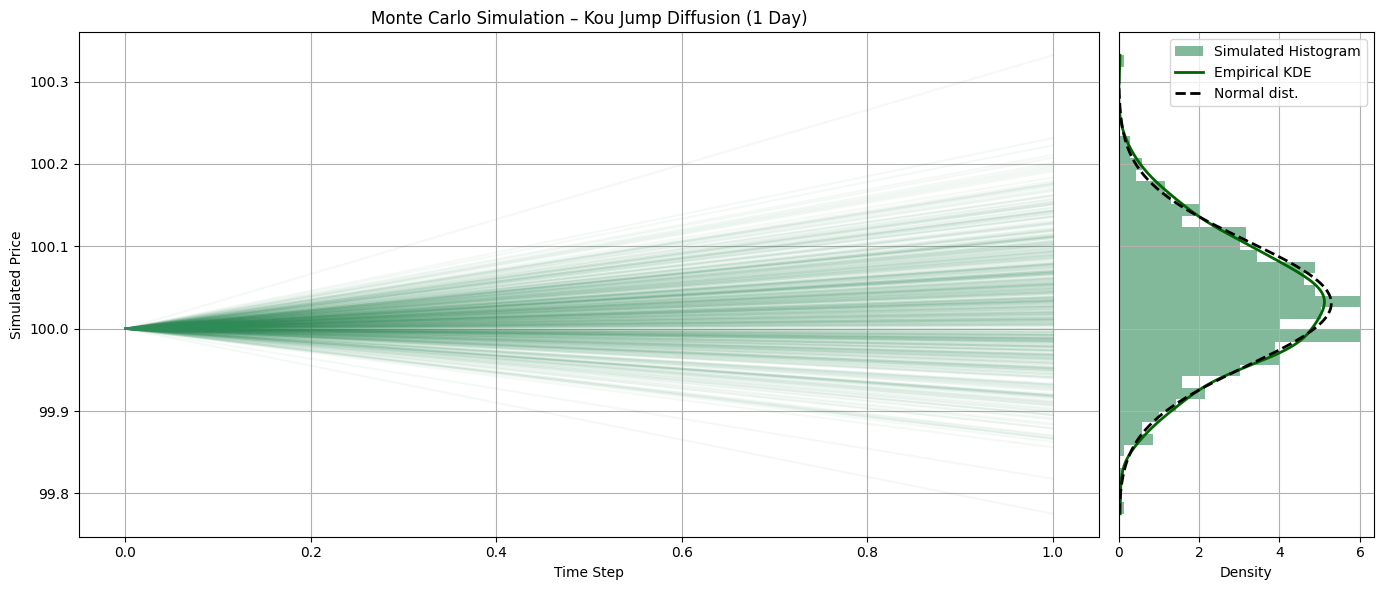

In [181]:
# Trajectiores simulation
n_paths = 500
T = 1 / 252
dt = T
np.random.seed(42)

S_paths = np.zeros(n_paths)
all_paths = []

for i in range(n_paths):
    Z = np.random.normal(0, 1)
    jumps_count = np.random.poisson(lambda_jump * dt)
    J = 0
    for _ in range(jumps_count):
        if np.random.rand() < p_kou:
            J += np.random.exponential(1 / eta1_kou)
        else:
            J -= np.random.exponential(1 / eta2_kou)
    S1 = S0 * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z + J)
    S_paths[i] = S1
    all_paths.append([S0, S1])

all_paths = np.array(all_paths).T

# Densities
kde = gaussian_kde(S_paths)
y_vals = np.linspace(min(S_paths), max(S_paths), 200)
kde_vals = kde(y_vals)

# Normal distribution with same mean and std as S_paths
mu_emp = np.mean(S_paths)
sigma_emp = np.std(S_paths)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# Combined Plot
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], all_paths[:, i], alpha=0.05, color='seagreen')
ax0.set_title("Monte Carlo Simulation – Kou Jump Diffusion (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_paths, bins=40, orientation='horizontal', color='seagreen', alpha=0.6, density=True, label="Simulated Histogram")
ax1.plot(kde_vals, y_vals, color='darkgreen', lw=2, label="Empirical KDE")
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label="Normal dist.")
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.show()

## Rough Volatility Models

### VaR simulation using Rough Volatility model

In [192]:
#Calibration
# 1. Mean volatility
xi_0 = sp500_data["realized_volatility_20d"].mean()

# 2. Volatility of the volatility
nu = sp500_data["realized_volatility_20d"].std()

# 4. Hurst exponent estimation
H, _, _ = compute_Hc(sp500_data["realized_volatility_20d"], kind='price')

#Simulation
S_rough = np.zeros(n_sim)
returns_rough = np.zeros(n_sim)

for i in range(n_sim):
    f = FBM(n=1, hurst=H, length=T, method='daviesharte')
    W_H = f.fbm()[1]
    sigma_t = xi_0 * np.exp(nu * W_H - 0.5 * (nu**2) * T**(2 * H))
    Z = np.random.normal(0, 1)
    S1 = S0 * np.exp((mu - 0.5 * sigma_t**2) * T + sigma_t * np.sqrt(T) * Z)
    S_rough[i] = S1
    returns_rough[i] = (S1 - S0) / S0

#VaR Computation
VaR_95_rough = -np.percentile(returns_rough, 5) * S0
VaR_99_rough = -np.percentile(returns_rough, 1) * S0

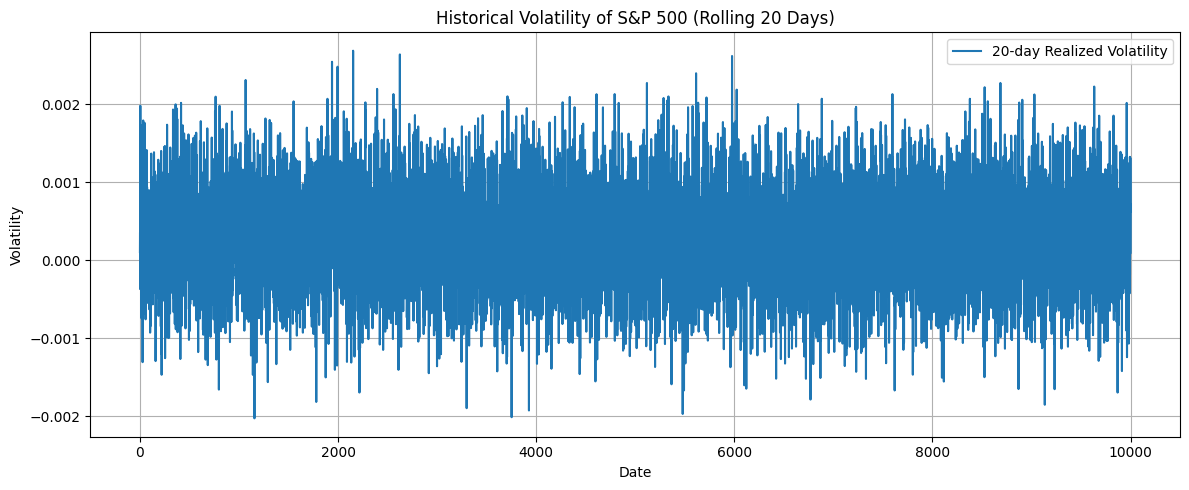

In [193]:
plt.figure(figsize=(12, 5))
plt.plot(returns_rough, label="20-day Realized Volatility")
plt.title("Historical Volatility of S&P 500 (Rolling 20 Days)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [194]:
print(f"Calibrated parameters:")
print(f"  μ (drift, annualized): {mu:.4f}")
print(f"  ξ₀ (mean volatility): {xi_0:.4f}")
print(f"  ν (vol of vol): {nu:.4f}")
print(f"  H (Hurst exponent): {H:.4f}")

print(f"\nRough Volatility VaR:")
print(f"  VaR 95%: {VaR_95_rough:.4f}")
print(f"  VaR 99%: {VaR_99_rough:.4f}")

Calibrated parameters:
  μ (drift, annualized): 0.0739
  ξ₀ (mean volatility): 0.0102
  ν (vol of vol): 0.0072
  H (Hurst exponent): 0.7041

Rough Volatility VaR:
  VaR 95%: 0.0761
  VaR 99%: 0.1151


#### Other plots (Rough)

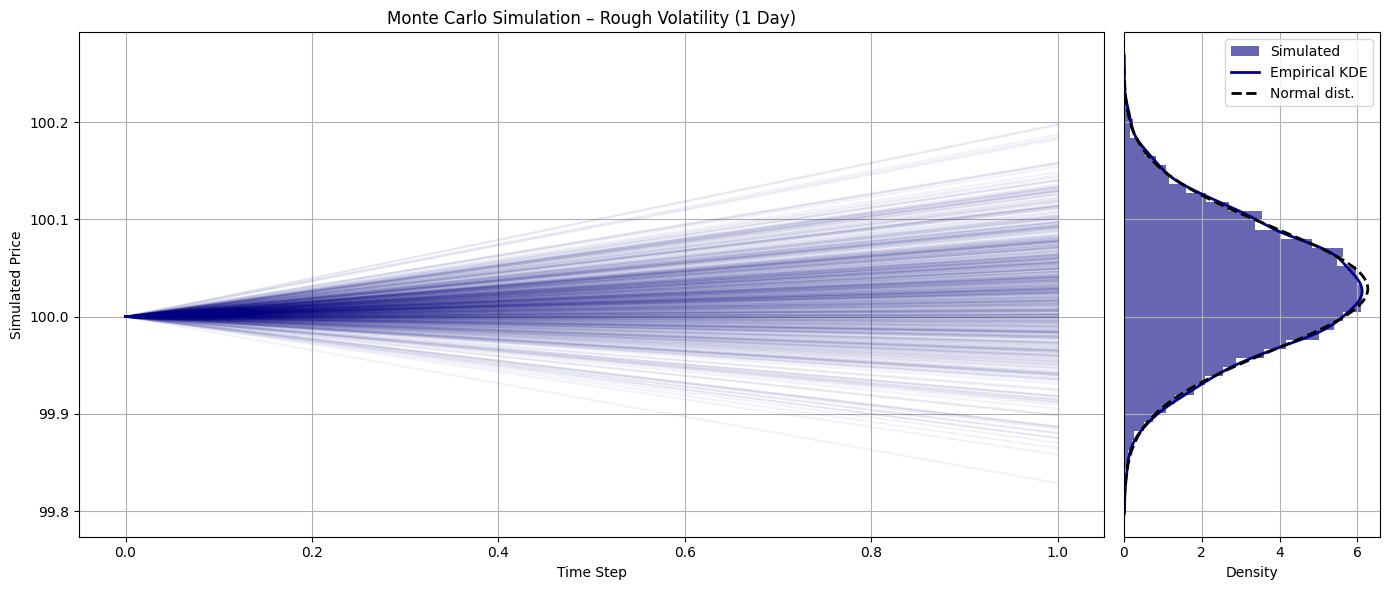

In [ ]:
# Combined plot trajectories----------------------------------------------------------------------------
n_paths = 500
simulated_paths = []
for i in range(n_paths):
    f = FBM(n=1, hurst=H, length=T, method='daviesharte')
    W_H = f.fbm()[1]
    sigma_t = xi_0 * np.exp(nu * W_H - 0.5 * (nu**2) * T**(2 * H))
    Z = np.random.normal(0, 1)
    S1 = S0 * np.exp((mu - 0.5 * sigma_t**2) * T + sigma_t * np.sqrt(T) * Z)
    simulated_paths.append([S0, S1])

simulated_paths = np.array(simulated_paths).T

# Densities
kde = gaussian_kde(S_rough)
y_vals = np.linspace(min(S_rough), max(S_rough), 200)
kde_vals = kde(y_vals)
mu_emp = np.mean(S_rough)
sigma_emp = np.std(S_rough)
norm_vals = norm.pdf(y_vals, loc=mu_emp, scale=sigma_emp)

# Plot
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[4, 1])

# Trajectories
ax0 = plt.subplot(gs[0])
for i in range(n_paths):
    ax0.plot([0, 1], simulated_paths[:, i], alpha=0.05, color='navy')
ax0.set_title("Monte Carlo Simulation – Rough Volatility (1 Day)")
ax0.set_xlabel("Time Step")
ax0.set_ylabel("Simulated Price")
ax0.grid(True)

# Distribution
ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.hist(S_rough, bins=50, orientation='horizontal', density=True, alpha=0.6, color='navy', label='Simulated')
ax1.plot(kde_vals, y_vals, color='darkblue', lw=2, label='Empirical KDE')
ax1.plot(norm_vals, y_vals, color='black', linestyle='--', lw=2, label='Normal dist.')
ax1.set_xlabel("Density")
ax1.set_xlim(left=0)
ax1.grid(True)
ax1.tick_params(left=False, labelleft=False)
ax1.legend()

plt.tight_layout()
plt.show()

## Model Comparisons and Backtesting

### Internal consistency

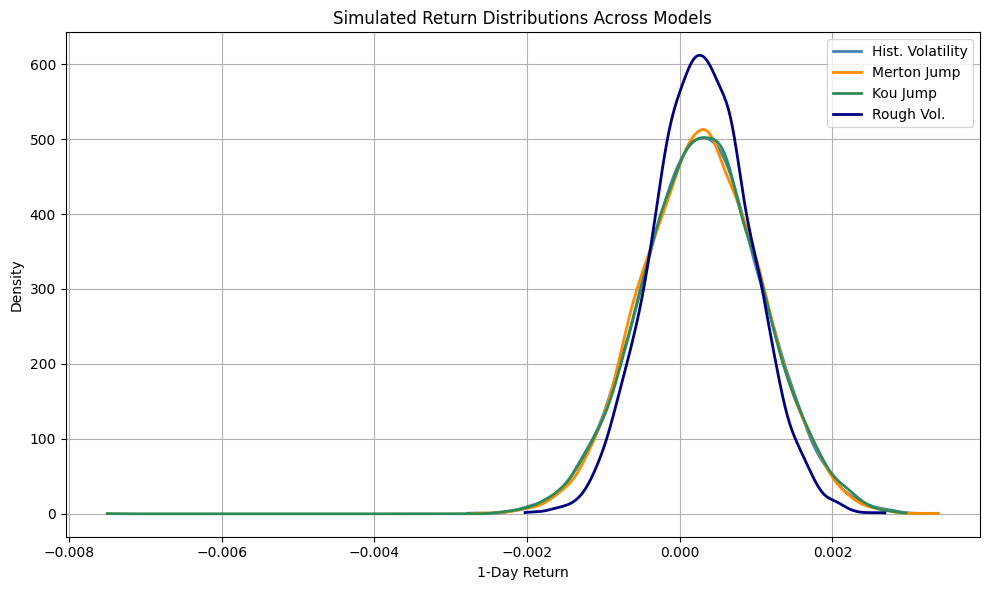

In [196]:
plt.figure(figsize=(10, 6))

for returns, label, color in zip(
    [returns_hist, returns_jump, returns_kou, returns_rough],
    ['Hist. Volatility', 'Merton Jump', 'Kou Jump', 'Rough Vol.'],
    ['steelblue', 'darkorange', 'seagreen', 'navy']
):
    kde = gaussian_kde(returns)
    x_vals = np.linspace(min(returns), max(returns), 300)
    plt.plot(x_vals, kde(x_vals), label=label, lw=2, color=color)

plt.title('Simulated Return Distributions Across Models')
plt.xlabel('1-Day Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [198]:
summary = pd.DataFrame({
    'Model': ['Hist. Volatility', 'Merton Jump', 'Kou Jump', 'Rough Vol.'],
    'VaR 95%': [
        -np.percentile(returns_hist, 5) * S0,
        -np.percentile(returns_jump, 5) * S0,
        -np.percentile(returns_kou, 5) * S0,
        -np.percentile(returns_rough, 5) * S0
    ],
    'VaR 99%': [
        -np.percentile(returns_hist, 1) * S0,
        -np.percentile(returns_jump, 1) * S0,
        -np.percentile(returns_kou, 1) * S0,
        -np.percentile(returns_rough, 1) * S0
    ],
    'Kurtosis': [
        kurtosis(returns_hist, fisher=False),
        kurtosis(returns_jump, fisher=False),
        kurtosis(returns_kou, fisher=False),
        kurtosis(returns_rough, fisher=False)
    ]
})

print(summary)

              Model   VaR 95%   VaR 99%  Kurtosis
0  Hist. Volatility  0.100434  0.152572  3.026481
1       Merton Jump  0.096625  0.151131  2.947960
2          Kou Jump  0.101305  0.154268  3.851136
3        Rough Vol.  0.076078  0.115093  2.972873


### Sensitivity Analysis

#### Historical Volatility

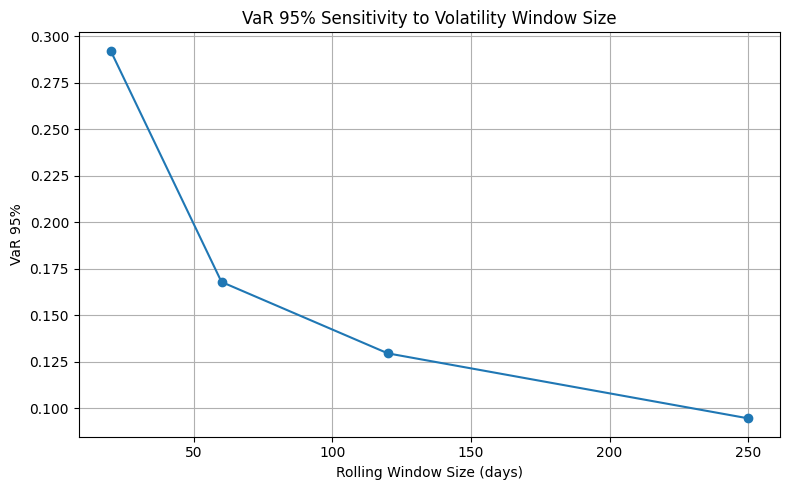

In [199]:
window_sizes = [20, 60, 120, 250]
var_95_values = []

for w in window_sizes:
    sigma_w = sp500_data["Log_return"].rolling(window=w).std().iloc[-1]
    Z = np.random.normal(0, 1, 10000)
    returns = (S0 * np.exp((mu - 0.5 * sigma_w**2) * T + sigma_w * np.sqrt(T) * Z) - S0) / S0
    var_95 = -np.percentile(returns, 5) * S0
    var_95_values.append(var_95)

# Plot
plt.figure(figsize=(8,5))
plt.plot(window_sizes, var_95_values, marker='o')
plt.title('VaR 95% Sensitivity to Volatility Window Size')
plt.xlabel('Rolling Window Size (days)')
plt.ylabel('VaR 95%')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Jump-Diffusion Models (Merton/Kou)

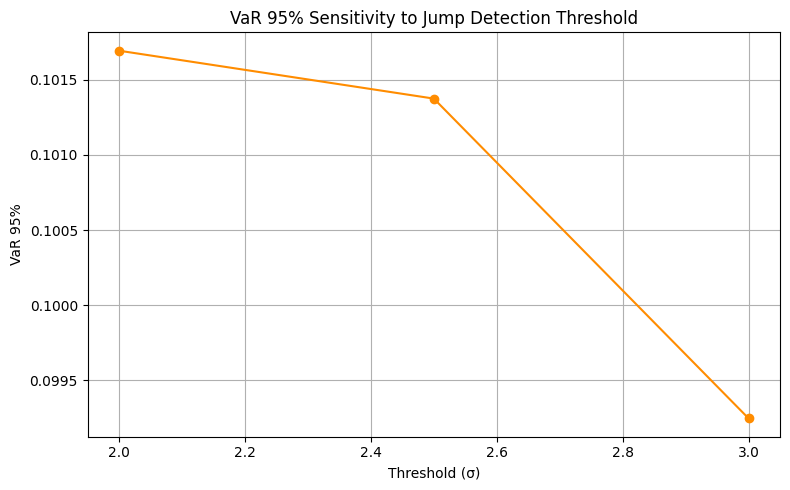

In [254]:
thresholds = [2.0, 2.5, 3.0]
var_95_jump = []

for th in thresholds:
    jumps = returns[np.abs(returns) > th * sigma]
    
    if len(jumps) < 5:
        print(f"Warning: threshold {th}σ → not enough jumps ({len(jumps)}), skipping.")
        var_95_jump.append(np.nan)
        continue
    
    lambda_jump = len(jumps) / len(returns)
    mu_J = jumps.mean()
    sigma_J = jumps.std()

    N_jumps = np.random.poisson(lambda_jump * T, n_sim)
    J = np.random.normal(mu_J, sigma_J, n_sim) * N_jumps
    Z = np.random.normal(0, 1, n_sim)
    S_jump = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z + J)
    returns_jump = (S_jump - S0) / S0
    var_95 = -np.percentile(returns_jump, 5) * S0
    var_95_jump.append(var_95)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, var_95_jump, marker='o', color='darkorange')
plt.title('VaR 95% Sensitivity to Jump Detection Threshold')
plt.xlabel('Threshold (σ)')
plt.ylabel('VaR 95%')
plt.grid(True)
plt.tight_layout()
plt.show()


# Rough Model

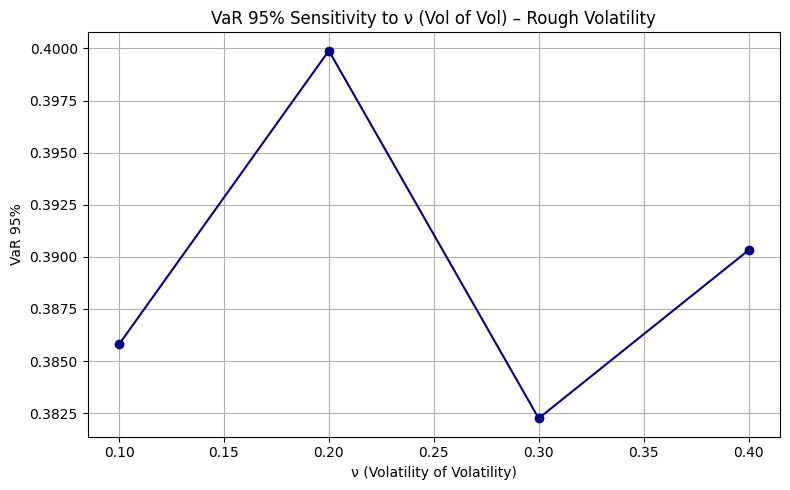

In [255]:
from fbm import FBM

nu_values = [0.1, 0.2, 0.3, 0.4]
var_95_rough = []

for nu in nu_values:
    returns_list = []
    for _ in range(10000):
        f = FBM(n=1, hurst=H, length=T, method='daviesharte')
        W_H = f.fbm()[1]
        sigma_t = xi_0 * np.exp(nu * W_H - 0.5 * (nu**2) * T**(2 * H))
        Z = np.random.normal(0, 1)
        S1 = S0 * np.exp((mu - 0.5 * sigma_t**2) * T + sigma_t * np.sqrt(T) * Z)
        returns_list.append((S1 - S0) / S0)
    var_95 = -np.percentile(returns_list, 5) * S0
    var_95_rough.append(var_95)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(nu_values, var_95_rough, marker='o', color='navy')
plt.title('VaR 95% Sensitivity to ν (Vol of Vol) – Rough Volatility')
plt.xlabel('ν (Volatility of Volatility)')
plt.ylabel('VaR 95%')
plt.grid(True)
plt.tight_layout()
plt.show()


### Stress Testing

#### Historical Volatility

#### Jump-Diffusion Models (Merton/Kou)

### Other plots and analysis

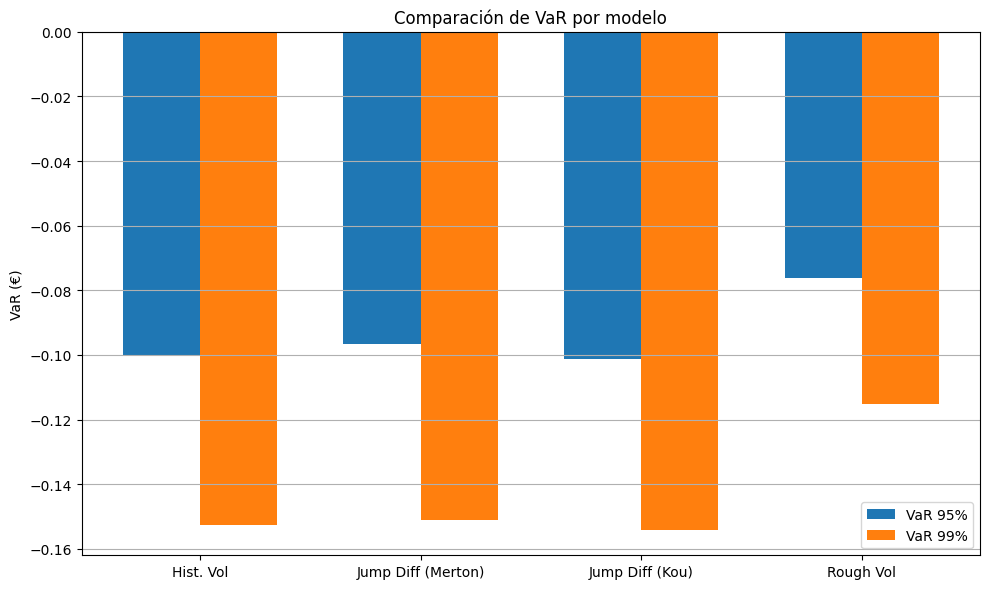

In [256]:
labels = ['Hist. Vol', 'Jump Diff (Merton)', 'Jump Diff (Kou)', 'Rough Vol']
VaR_95_values = [-VaR_95_hist, -VaR_95_Merton, -VaR_95_kou, -VaR_95_rough]
VaR_99_values = [-VaR_99_hist, -VaR_99_Merton, -VaR_99_kou, -VaR_99_rough]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, VaR_95_values, width, label='VaR 95%')
rects2 = ax.bar(x + width/2, VaR_99_values, width, label='VaR 99%')

ax.set_ylabel('VaR (€)')
ax.set_title('Comparación de VaR por modelo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()